Link to the dataset: http://www.nlpr.ia.ac.cn/pal/trafficdata/recognition.html

# Chinese Traffic Sign Recognition. Part I

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
from skimage import color, exposure, transform

In [2]:
from sklearn.metrics import accuracy_score, f1_score

In [3]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

Using TensorFlow backend.


In [4]:
from keras.preprocessing.image import ImageDataGenerator

In [5]:
from skimage import io
import os
import glob

In [6]:
import random
import matplotlib.pyplot as plt

In [7]:
from keras.optimizers import SGD
from cnn import cnn

In [8]:
import warnings
warnings.filterwarnings("ignore")

# Part I: Using CNN for classification

### Load training and test data

In [9]:
img_size = 50

In [10]:
def preproc_img(img, img_size):
    # Histogram normalization
    hsv = color.rgb2hsv(img)
    hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
    img = color.hsv2rgb(hsv)

    # central square crop
    min_side = min(img.shape[:-1])
    centre = img.shape[0] // 2, img.shape[1] // 2
    img = img[centre[0] - min_side // 2:centre[0] + min_side // 2,
              centre[1] - min_side // 2:centre[1] + min_side // 2,:]

    # rescale to standard size
    img = transform.resize(img, (img_size, img_size))

    # roll color axis to axis 0
    img = np.rollaxis(img, -1)
    
    return img

In [11]:
#return image class
def get_class(img_path):
    return int(img_path.split('/')[-1].split('_')[0])


In [12]:
get_class('chn/train_images/026_0003.png')

26

In [13]:
%%time
# Load training dataset
root_dir = 'сhn/train_images/'
imgs = []
imgs_row = []
labels = []

all_img_paths = glob.glob(os.path.join(root_dir,'*.png'))
#get images and classes
for img_path in all_img_paths:
    im = io.imread(img_path)
    imgs_row.append(transform.resize(im,(img_size, img_size)))
    img = preproc_img(im, img_size)
    label = get_class(img_path)
    imgs.append(img)
    labels.append(label)
#count number of classes
num_classes = len(set(labels))

X_train_row = np.array(imgs_row, dtype='float32')

X_train = np.array(imgs, dtype='float32')

# Make one hot targets
y_train = np.eye(num_classes, dtype='uint8')[labels]

CPU times: user 4min 23s, sys: 3.41 s, total: 4min 26s
Wall time: 1min 7s


In [14]:
print('Number of classes: ', num_classes)

Number of classes:  58


In [15]:
X_train.shape

(4170, 3, 50, 50)

In [16]:
y_train.shape

(4170, 58)

In [17]:
%%time
#Load test data
root_dir = 'сhn/test_images/'
imgs_test = []
labels_test = []

all_img_paths = glob.glob(os.path.join(root_dir, '*.png'))
np.random.shuffle(all_img_paths)
for img_path in all_img_paths:
    img = preproc_img(io.imread(img_path), img_size)
    label = get_class(img_path)
    imgs_test.append(img)
    labels_test.append(label)

X_test = np.array(imgs_test, dtype='float32')
y_test = np.array(labels_test)

CPU times: user 1min 6s, sys: 576 ms, total: 1min 7s
Wall time: 18.2 s


In [18]:
X_test.shape

(1994, 3, 50, 50)

In [19]:
sign_classes, class_indices, class_counts = np.unique(labels, return_index = True, return_counts = True)

In [20]:
sign_classes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57])

In [21]:
class_indices

array([   3,    9,  105,   41,   32,   27,   20,   24,  171,  433,   62,
         18,   23,   22,   30,  327,   54,   51, 1464, 1679,  125,  405,
         72,  490,   15, 1657,    0,  471,   16,   29,   40,  109,  271,
        814,  303,   44,  120,  432,   31,   75,   52,  138,  124,   11,
         56,   79,   28,  424,  382,   39,   13,  170,  122,  371,    6,
          1,    4,  647])

In [22]:
class_counts

array([118,  40,  80, 260,  98, 194,  78, 152,   8,   2,  70, 138,  96,
        36, 128,  22, 142, 130,   8,   4,  18,  12,  18,  14, 100,   2,
       126,  28, 446,  44, 150,  42,  14,   4,  26, 156,  40,  58,  30,
        34,  32,  18,  32,  82,  30,  24,  18,  12,  10,  42,  56,   8,
        36,   2, 324, 162, 110,   6])

### Show training data

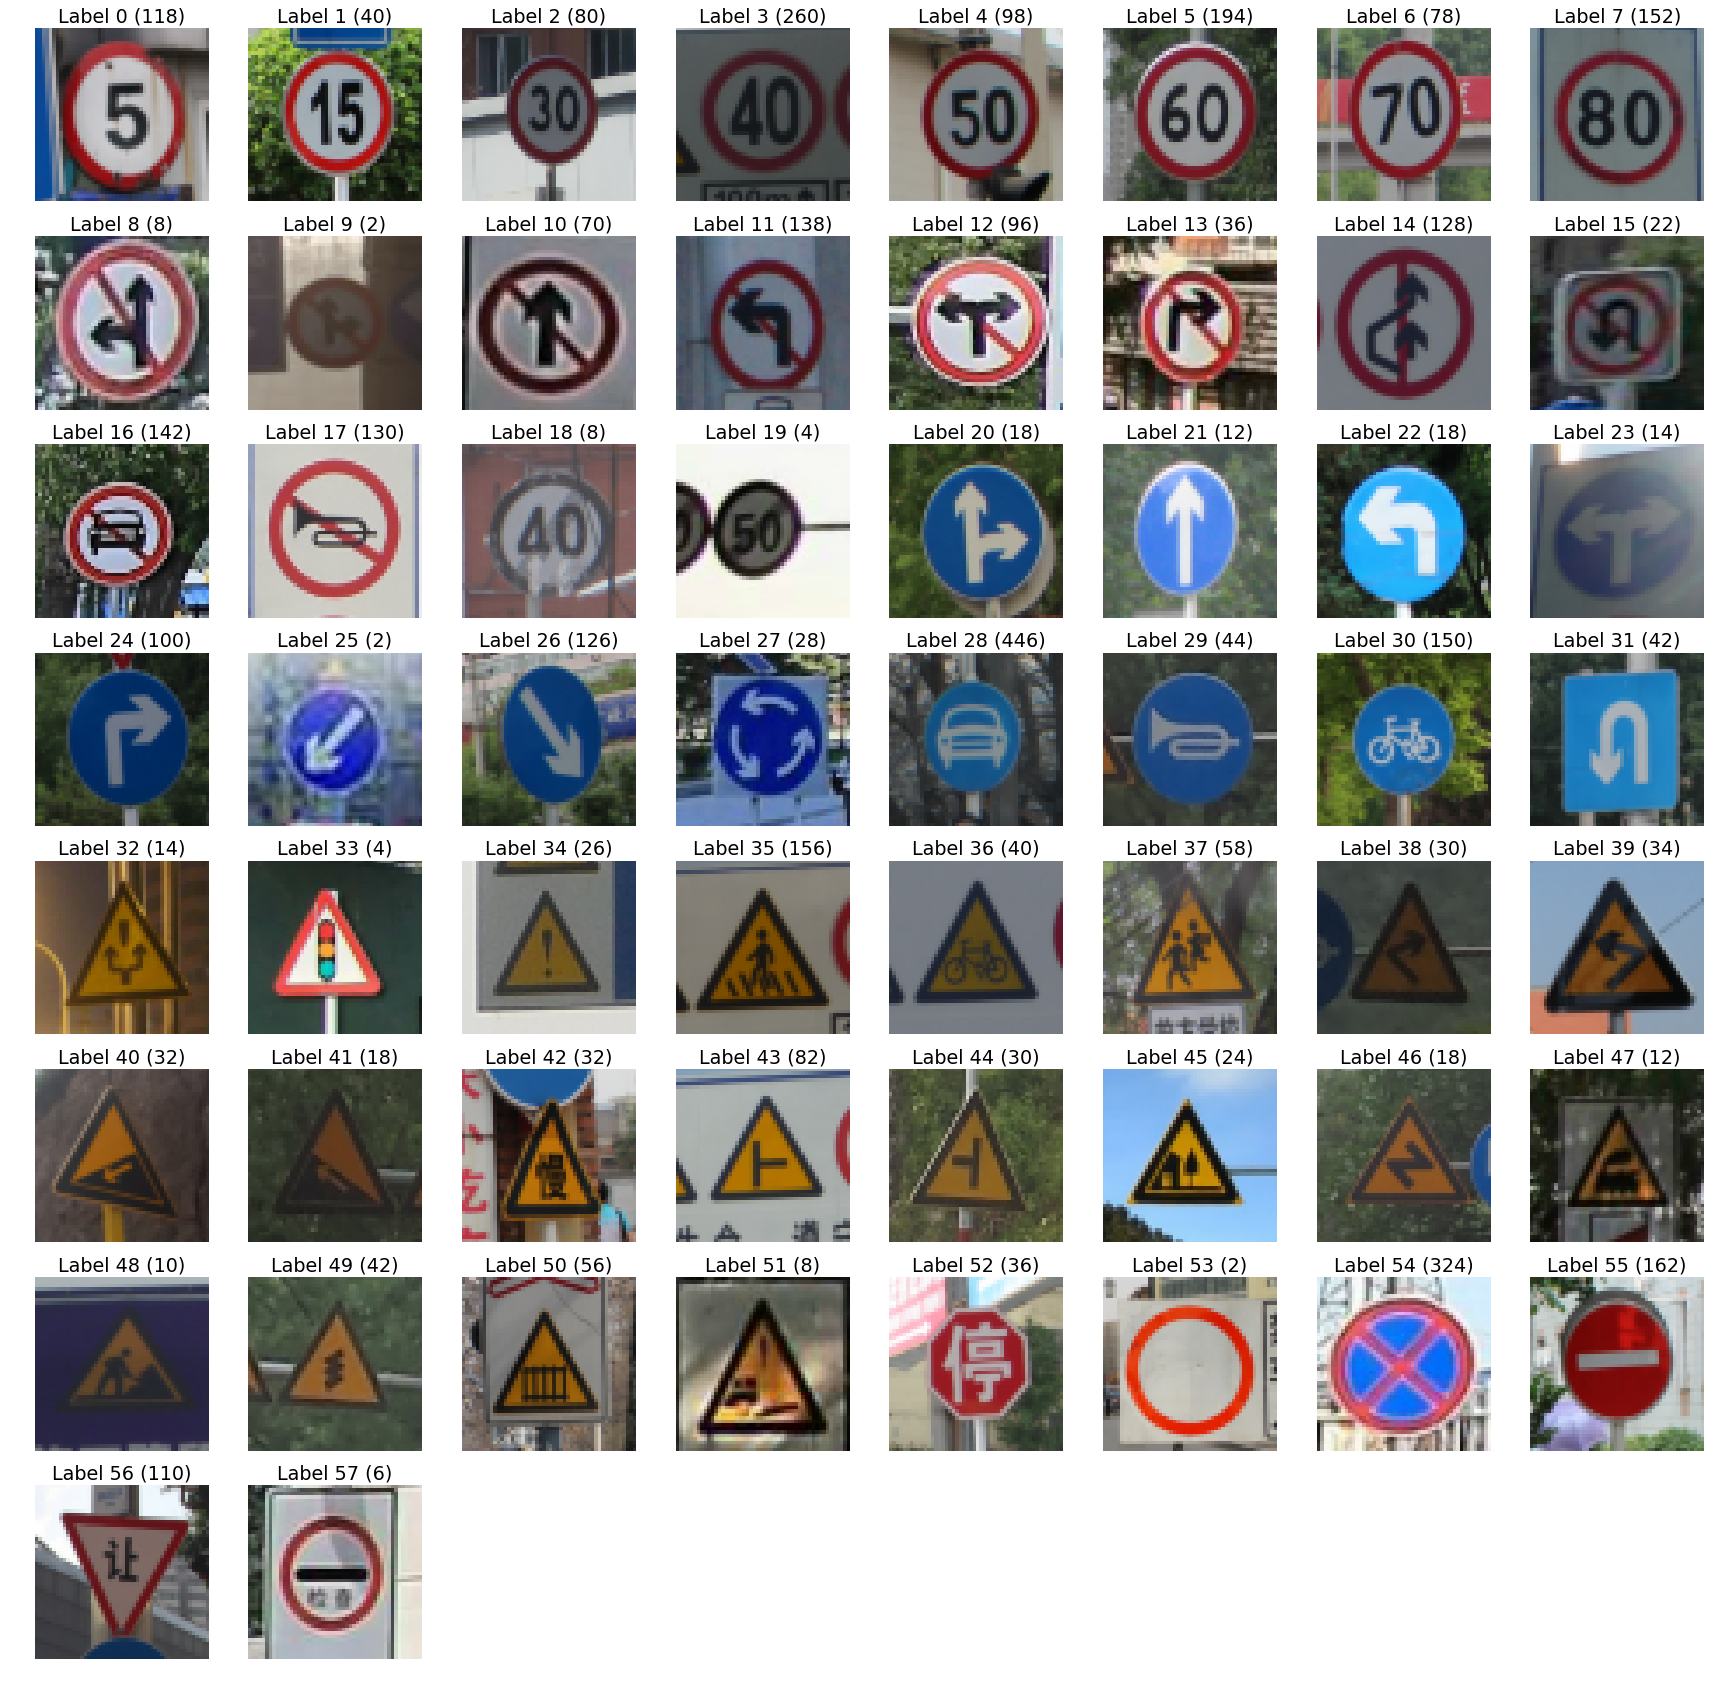

In [23]:
plt.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(30,30))
i = 1
for c, c_index, c_count in zip(sign_classes, class_indices, class_counts):
    #print("Class %i: %s samples" % (c, str(c_count)))
    #plt.figure(figsize=(1,1))
    plt.subplot(8, 8, i)
    i+=1
    plt.title("Label %i (%s)" % (c, str(c_count)))
    plt.axis('off')
    plt.imshow(X_train_row[c_index])
plt.show()
fig.savefig('all_classes.png')

As can be seen from the images above, dataset is unbalanced. Furthermore, it only have 4170 images which is usually not enought to get good results. To solve these problems it can be used class weights or data augmentation.

### Train CNN

In [24]:
#create model instance
model = cnn(img_size,num_classes)

lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [25]:
#Learning rate scheduler
def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

batch_size = 32
epochs = 15

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=[LearningRateScheduler(lr_schedule),
                     ModelCheckpoint('model.h5', save_best_only=True)]
          )

Train on 3336 samples, validate on 834 samples
Epoch 1/15
3336/3336 [==============================] - 69s 21ms/step - loss: 3.6883 - acc: 0.0920 - val_loss: 3.4146 - val_acc: 0.1667
Epoch 2/15
3336/3336 [==============================] - 68s 20ms/step - loss: 2.8871 - acc: 0.2590 - val_loss: 2.5556 - val_acc: 0.3825
Epoch 3/15
3336/3336 [==============================] - 76s 23ms/step - loss: 1.9457 - acc: 0.4814 - val_loss: 1.4877 - val_acc: 0.5935
Epoch 4/15
3336/3336 [==============================] - 78s 23ms/step - loss: 1.1424 - acc: 0.6814 - val_loss: 0.9418 - val_acc: 0.7506
Epoch 5/15
3336/3336 [==============================] - 78s 23ms/step - loss: 0.7350 - acc: 0.7875 - val_loss: 0.5821 - val_acc: 0.8513
Epoch 6/15
3336/3336 [==============================] - 76s 23ms/step - loss: 0.5167 - acc: 0.8504 - val_loss: 0.5880 - val_acc: 0.8213
Epoch 7/15
3336/3336 [==============================] - 76s 23ms/step - loss: 0.3712 - acc: 0.8885 - val_loss: 0.3521 - val_acc: 0.8957
E

In [26]:
# predict 
pred = model.predict_classes(X_test)

In [27]:
pred

array([54, 12, 43, ..., 28, 54, 54])

In [28]:
accuracy_score(pred,labels_test)

0.7051153460381143

In [29]:
f1_score(pred,labels_test, average = 'weighted')

0.7061997820734702

#### Fit the model without validation split

In [30]:
#create model instance
model3 = cnn(img_size,num_classes)

lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)

model3.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [31]:
batch_size = 32
epochs = 15

model3.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[LearningRateScheduler(lr_schedule),
                     ModelCheckpoint('model.h5', save_best_only=True)]
          )

Epoch 1/15
4170/4170 [==============================] - 85s 20ms/step - loss: 3.6722 - acc: 0.0918
Epoch 2/15
4170/4170 [==============================] - 86s 21ms/step - loss: 2.9516 - acc: 0.2369
Epoch 3/15
4170/4170 [==============================] - 83s 20ms/step - loss: 1.8891 - acc: 0.4887
Epoch 4/15
4170/4170 [==============================] - 82s 20ms/step - loss: 0.9530 - acc: 0.7288
Epoch 5/15
4170/4170 [==============================] - 85s 20ms/step - loss: 0.5834 - acc: 0.8446
Epoch 6/15
4170/4170 [==============================] - 85s 20ms/step - loss: 0.3805 - acc: 0.8859
Epoch 7/15
4170/4170 [==============================] - 85s 20ms/step - loss: 0.2183 - acc: 0.9391
Epoch 8/15
4170/4170 [==============================] - 85s 20ms/step - loss: 0.1663 - acc: 0.9516
Epoch 9/15
4170/4170 [==============================] - 87s 21ms/step - loss: 0.1833 - acc: 0.9496
Epoch 10/15
4170/4170 [==============================] - 82s 20ms/step - loss: 0.1594 - acc: 0.9609
Epoch 11/

In [32]:
# predict 
pred3 = model3.predict_classes(X_test)

In [33]:
accuracy_score(pred3,labels_test)

0.7412236710130391

In [34]:
f1_score(pred3,labels_test, average = 'weighted')

0.7440387598573985

### Keras automatic data augmentation

In [35]:
#create model instance
model2 = cnn(img_size,num_classes)

lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)

model2.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [36]:
datagen = ImageDataGenerator()

In [37]:
datagen.fit(X_train)

In [38]:
# fits the model on batches with real-time data augmentation:
model2.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                     steps_per_epoch=len(X_train)/ 32, 
                     epochs=15)

Epoch 1/15
131/130 [==============================] - 85s 645ms/step - loss: 3.5987 - acc: 0.1098
Epoch 2/15
131/130 [==============================] - 83s 631ms/step - loss: 1.9420 - acc: 0.4771
Epoch 3/15
131/130 [==============================] - 83s 636ms/step - loss: 0.9087 - acc: 0.7365
Epoch 4/15
131/130 [==============================] - 82s 629ms/step - loss: 0.5520 - acc: 0.8332
Epoch 5/15
131/130 [==============================] - 83s 635ms/step - loss: 0.4268 - acc: 0.8742
Epoch 6/15
131/130 [==============================] - 83s 632ms/step - loss: 0.2585 - acc: 0.9246
Epoch 7/15
131/130 [==============================] - 82s 628ms/step - loss: 0.1756 - acc: 0.9513
Epoch 8/15
131/130 [==============================] - 83s 633ms/step - loss: 0.1654 - acc: 0.9489
Epoch 9/15
131/130 [==============================] - 82s 624ms/step - loss: 0.1573 - acc: 0.9542
Epoch 10/15
131/130 [==============================] - 82s 628ms/step - loss: 0.1456 - acc: 0.9587
Epoch 11/15
131/130

In [39]:
pred2 = model2.predict_classes(X_test)

In [40]:
accuracy_score(pred2,labels_test)

0.7101303911735206

In [41]:
f1_score(pred2,labels_test, average = 'weighted')

0.703574925351918